# Painting Rainbows

This notebook does 3 effects based on k-means clustering of the image colors: 1) paints a vertical rainbow beam of representative colors in the center of the image, 2) paints targets using the same colors in the corners, and 3) adds a gaussian blurred radial filter of the centroid color bands. 

See the below examples of processed images.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from skimage.util import img_as_float, img_as_ubyte
import numpy as np
from skimage.color import rgb2hsv,hsv2rgb
from math import floor, sqrt, ceil
import random
import os
from skimage.transform import rescale
from scipy.ndimage import gaussian_filter

In [2]:
testfile = 'sunset.jpg'

testimage = mpimg.imread(testfile)
scalefactor = 1024 / max(testimage.shape[0],testimage.shape[1])
testimage = rescale(testimage, scalefactor, anti_aliasing=True, multichannel=True)

In [3]:
def clusterimage(image,numbercenters):
    image = img_as_float(image)
    pic_n = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    kmeans = KMeans(n_clusters=numbercenters, random_state=0,max_iter=3,n_init=1).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]    
    cluster_pic = pic2show.reshape(image.shape[0], image.shape[1], image.shape[2])
    return kmeans

testkmeans = clusterimage(testimage,7)

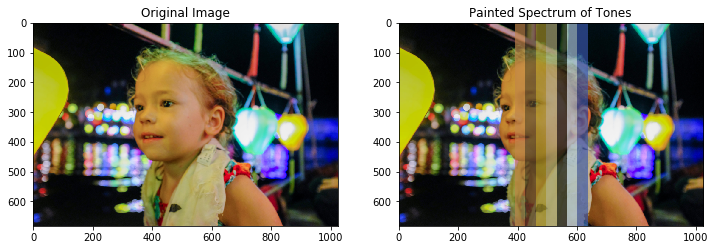

In [4]:
def drawtones(image,kmeans):
    numbercenters = kmeans.cluster_centers_.shape[0]
    rainbowwidth = 35
    horizonline = image.shape[0]
    alpha = 0.66
    supersaturate = False

    # First, reorder according to hue
    #    If Red is max, then Hue = (G-B)/(max-min)
    #If Green is max, then Hue = 2.0 + (B-R)/(max-min)
    #If Blue is max, then Hue = 4.0 + (R-G)/(max-min)
    huevalue = []
    for x in range(0,numbercenters):
        maxval = max(kmeans.cluster_centers_[x,:])
        maxind = np.argmax(kmeans.cluster_centers_[x,:]) 
        minval = min(kmeans.cluster_centers_[x,:])
        if maxind == 0:
            huevalue.append(60.0*(kmeans.cluster_centers_[x,1] - kmeans.cluster_centers_[x,2]) / (maxval-minval))
        elif maxind == 1:
            huevalue.append(60.0*(2.0 + (kmeans.cluster_centers_[x,2] - kmeans.cluster_centers_[x,0]) / (maxval-minval)))
        else:
            huevalue.append(60.0*(4.0 + (kmeans.cluster_centers_[x,0] - kmeans.cluster_centers_[x,1]) / (maxval-minval)))
        if huevalue[-1] < 0.0:
            huevalue[-1] = huevalue[-1] + 360.0
    
    centers = kmeans.cluster_centers_[np.argsort(huevalue),:]
        
    # Next let's draw up from a specified horizon line
    imgcpy = img_as_float(image.copy())
    outimg = img_as_float(image.copy())
    startpoint = floor(image.shape[1]/2 - (numbercenters/2)*rainbowwidth)
   
    for x in range(0,numbercenters):
        outimg[0:horizonline,startpoint+rainbowwidth*x:startpoint+rainbowwidth*(x+1),:] = centers[x,:]    
    
    # Supersaturate
    if supersaturate:
        outimg = rgb2hsv(outimg)
        outimg[0:horizonline,startpoint:startpoint+rainbowwidth*numbercenters,1] = 1.0
        outimg = hsv2rgb(outimg)
    
    outimg = alpha*outimg + (1-alpha)*imgcpy
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Painted Spectrum of Tones')
    ax2.imshow(outimg)

    return outimg

dtonesimg = drawtones(testimage,testkmeans)

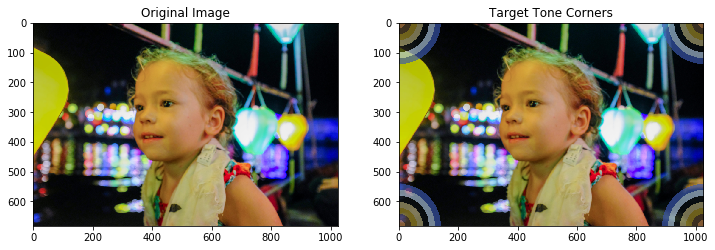

In [5]:
def tonecorners(image,kmeans):
    ## paints the tones as a vignette
    numbercenters = kmeans.cluster_centers_.shape[0]
    rainbowwidth = 20
    alpha = 0.66

    # First, reorder according to hue
    #    If Red is max, then Hue = (G-B)/(max-min)
    #If Green is max, then Hue = 2.0 + (B-R)/(max-min)
    #If Blue is max, then Hue = 4.0 + (R-G)/(max-min)
    huevalue = []
    for x in range(0,numbercenters):
        maxval = max(kmeans.cluster_centers_[x,:])
        maxind = np.argmax(kmeans.cluster_centers_[x,:]) 
        minval = min(kmeans.cluster_centers_[x,:])
        if maxind == 0:
            huevalue.append(60.0*(kmeans.cluster_centers_[x,1] - kmeans.cluster_centers_[x,2]) / (maxval-minval))
        elif maxind == 1:
            huevalue.append(60.0*(2.0 + (kmeans.cluster_centers_[x,2] - kmeans.cluster_centers_[x,0]) / (maxval-minval)))
        else:
            huevalue.append(60.0*(4.0 + (kmeans.cluster_centers_[x,0] - kmeans.cluster_centers_[x,1]) / (maxval-minval)))
        if huevalue[-1] < 0.0:
            huevalue[-1] = huevalue[-1] + 360.0
    
    centers = kmeans.cluster_centers_[np.argsort(huevalue),:]
        
    # Next let's party in the corners
    imgcpy = img_as_float(image.copy())
    outimg = img_as_float(image.copy())

    radius = 0
    for x in range(0,numbercenters):
        nextradius = radius + rainbowwidth
        for u in range(0,nextradius):
            for v in range(0,nextradius):
                if (sqrt(u*u+v*v) < nextradius) & (sqrt(u*u+v*v) >= radius):
                    outimg[u,v,:] = centers[x,:]
                    outimg[outimg.shape[0]-u-1,v,:] = centers[x,:]
                    outimg[u,outimg.shape[1]-v-1,:] = centers[x,:]
                    outimg[outimg.shape[0]-u-1,outimg.shape[1]-v-1,:] = centers[x,:]
        radius = nextradius

    outimg = alpha*outimg + (1-alpha)*imgcpy
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Target Tone Corners')
    ax2.imshow(outimg)

    return outimg

vignimg = tonecorners(testimage,testkmeans)

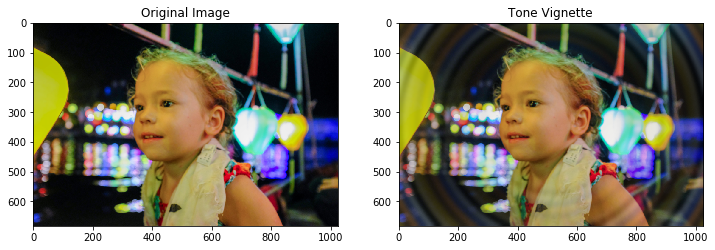

In [6]:
def tonevignette(image,kmeans):
    ## paints the tones as a vignette
    numbercenters = kmeans.cluster_centers_.shape[0]
    rainbowwidth = 20
    alphaconstant = 0.875
    withgaussian = True

    # First, reorder according to hue
    #    If Red is max, then Hue = (G-B)/(max-min)
    #If Green is max, then Hue = 2.0 + (B-R)/(max-min)
    #If Blue is max, then Hue = 4.0 + (R-G)/(max-min)
    huevalue = []
    for x in range(0,numbercenters):
        maxval = max(kmeans.cluster_centers_[x,:])
        maxind = np.argmax(kmeans.cluster_centers_[x,:]) 
        minval = min(kmeans.cluster_centers_[x,:])
        if maxind == 0:
            huevalue.append(60.0*(kmeans.cluster_centers_[x,1] - kmeans.cluster_centers_[x,2]) / (maxval-minval))
        elif maxind == 1:
            huevalue.append(60.0*(2.0 + (kmeans.cluster_centers_[x,2] - kmeans.cluster_centers_[x,0]) / (maxval-minval)))
        else:
            huevalue.append(60.0*(4.0 + (kmeans.cluster_centers_[x,0] - kmeans.cluster_centers_[x,1]) / (maxval-minval)))
        if huevalue[-1] < 0.0:
            huevalue[-1] = huevalue[-1] + 360.0
    
    centers = kmeans.cluster_centers_[np.argsort(huevalue),:]
        
    # Next let's party in the corners
    imgcpy = img_as_float(image.copy())
    outimg = img_as_float(image.copy())

    midx = ceil(image.shape[0]/2)
    midy = ceil(image.shape[1]/2)

    alpha = np.ones([image.shape[0],image.shape[1],3])
    for u in range(0,midx):
        for v in range(0,midy):
            values = centers[floor(sqrt(((u-midx)/rainbowwidth)*((u-midx)/rainbowwidth)+((v-midy)/rainbowwidth)*((v-midy)/rainbowwidth))) % (numbercenters),:]
            outimg[u,v,:] = values
            outimg[outimg.shape[0]-u-1,v,:] = values
            outimg[u,outimg.shape[1]-v-1,:] = values
            outimg[outimg.shape[0]-u-1,outimg.shape[1]-v-1,:] = values
            alphavalue = alphaconstant*0.5*((midx - u)**2 / midx**2 + (midy - v)**2 / midy**2 ) / 2.0
            alpha[u,v,:] = alphavalue 
            alpha[outimg.shape[0]-u-1,v] = alphavalue
            alpha[u,outimg.shape[1]-v-1,:] = alphavalue
            alpha[outimg.shape[0]-u-1,outimg.shape[1]-v-1,:] = alphavalue

    if withgaussian:
        outimg[:,:,0] = gaussian_filter(outimg[:,:,0], sigma=rainbowwidth/3)
        outimg[:,:,1] = gaussian_filter(outimg[:,:,1], sigma=rainbowwidth/3)
        outimg[:,:,2] = gaussian_filter(outimg[:,:,2], sigma=rainbowwidth/3)
        
    outimg = np.multiply(alpha,outimg) + np.multiply(1-alpha,imgcpy)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Tone Vignette')
    ax2.imshow(outimg)

    return outimg

vignimg = tonevignette(testimage,testkmeans)
plt.imsave('tonevignette.jpg', vignimg)

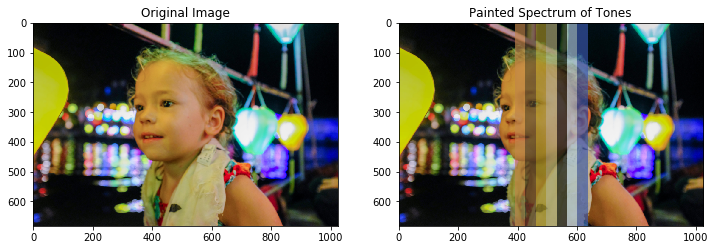

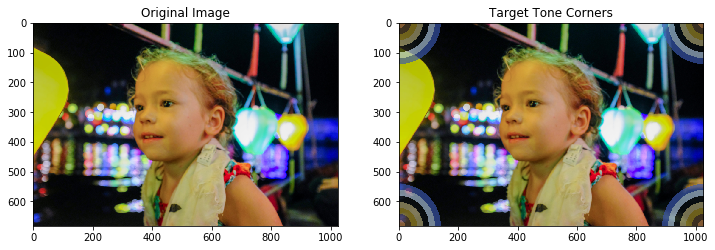

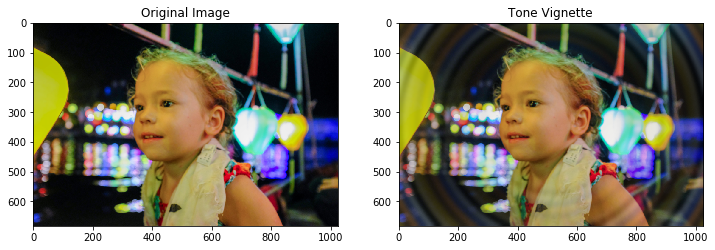

In [7]:
def rainbowsky(image):
    numbercenters = 7
    kmeans = clusterimage(image,numbercenters)
    outimages = []
    outimages.append(drawtones(image,kmeans))
    outimages.append(tonecorners(image,kmeans))
    outimages.append(tonevignette(image,kmeans))
    return outimages

outimglist = rainbowsky(testimage)

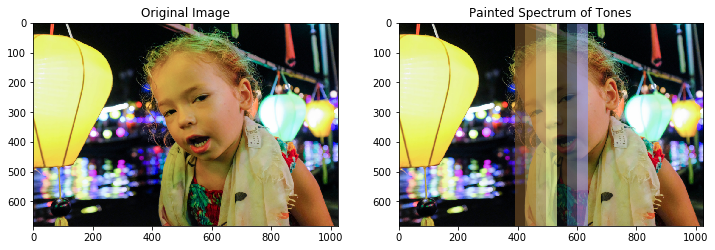

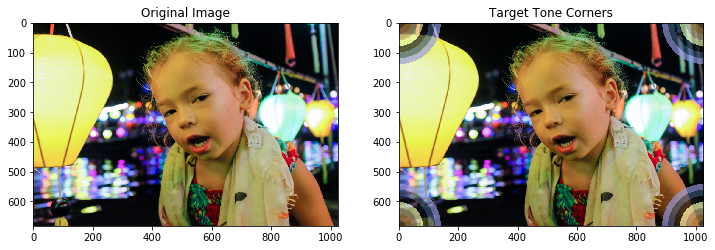

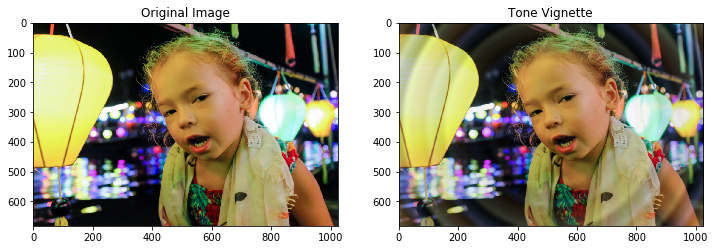

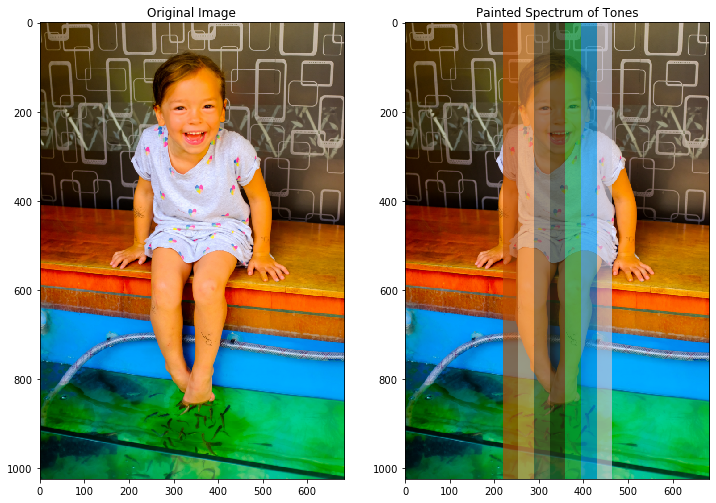

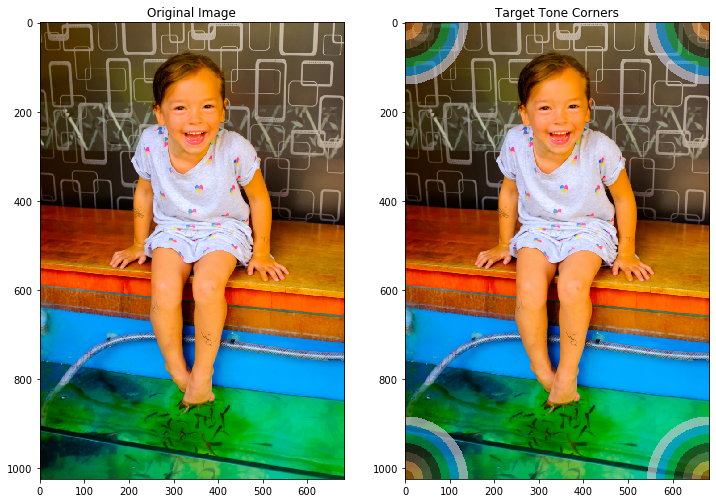

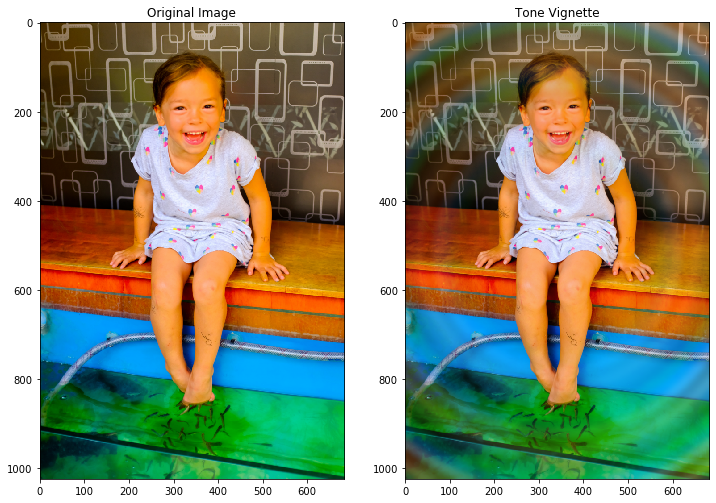

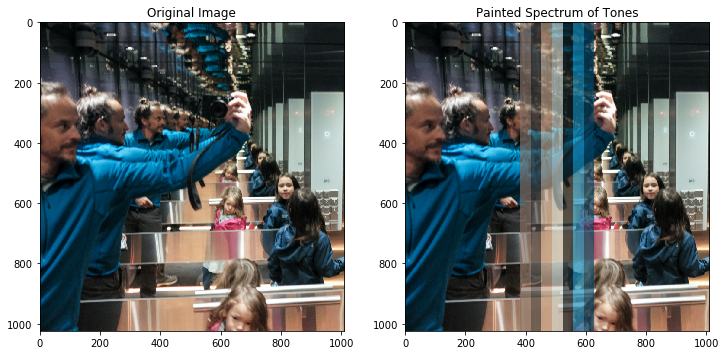

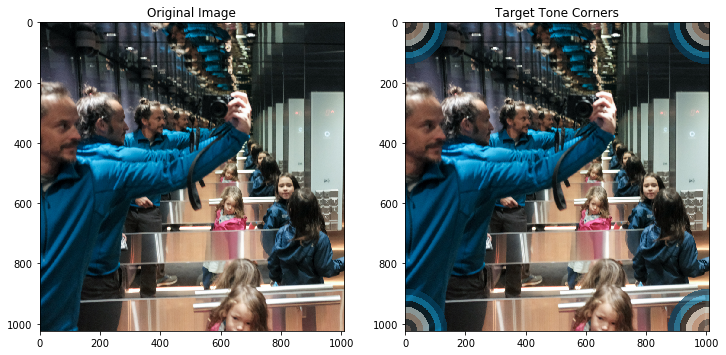

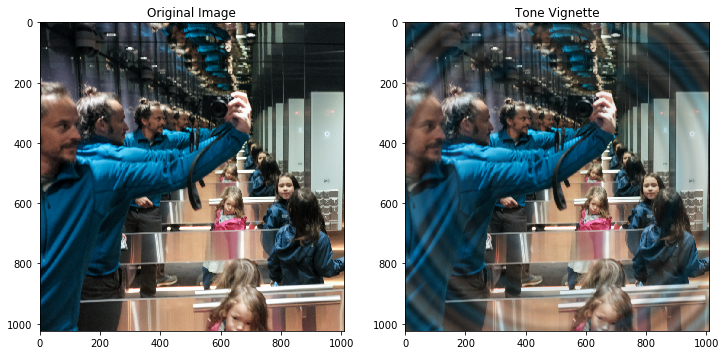

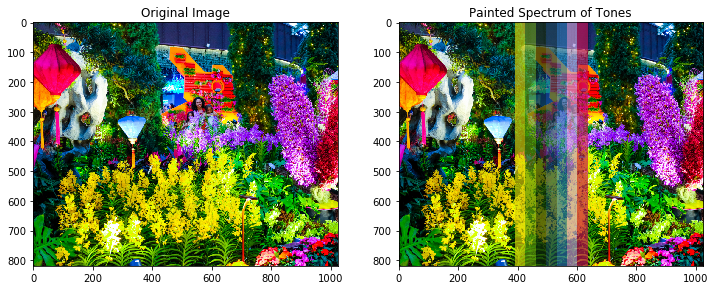

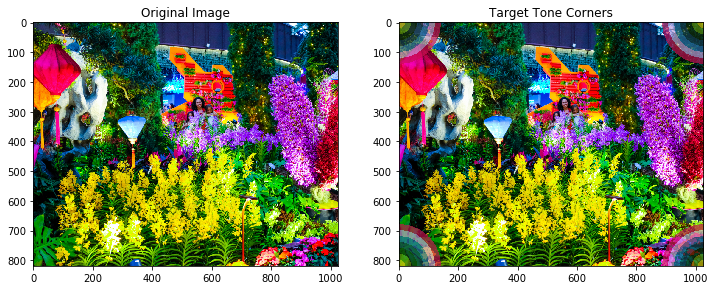

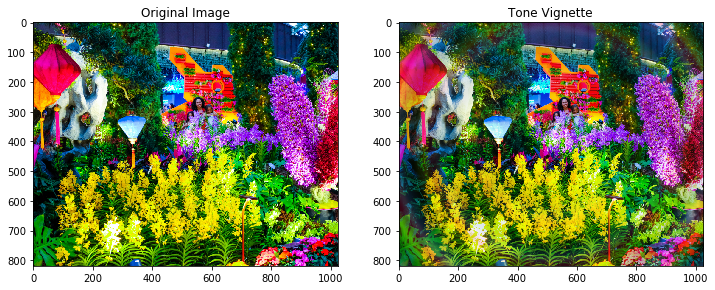

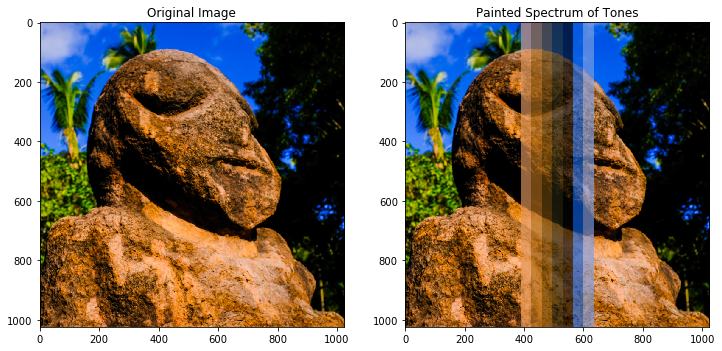

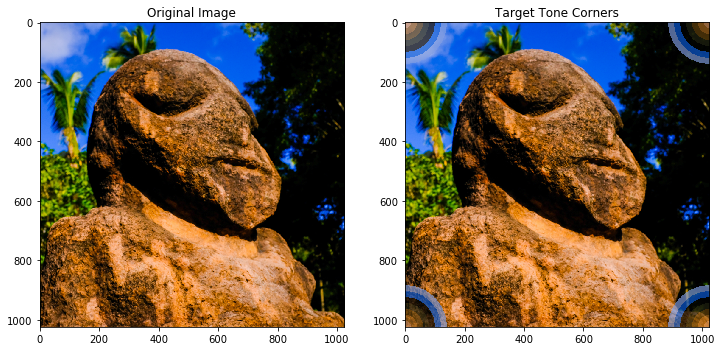

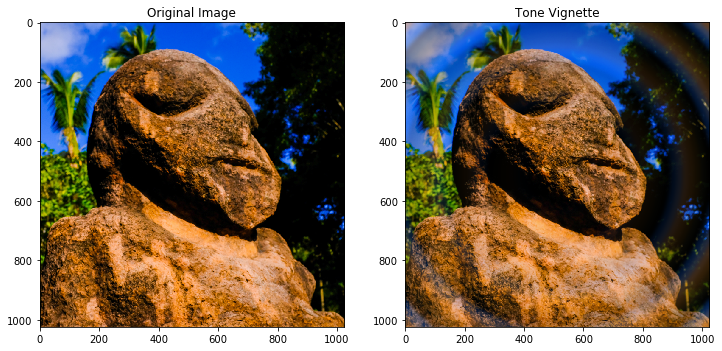

In [10]:
# load input files and set parameters
# this runs across a few random files in subdirectories specified under path
numberoffiles = 5

# Add parent directory with test photos here
path = '/Users/jimkleban/Desktop/Photos'
outpath = '/Users/jimkleban/Desktop/Autogenerated/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

random.shuffle(files)

for r in range(0,numberoffiles):
    img = mpimg.imread(files[r])
    scalefactor = 1024 / max(img.shape[0],img.shape[1])
    img = rescale(img, scalefactor, anti_aliasing=True, multichannel=True)
    outputimglist = rainbowsky(img)
    
    filebase = files[r].split('/')[-1]
    basename = filebase.split('.')[0]
    ext = filebase.split('.')[1]
    
    plt.imsave(outpath+basename+'_1024.'+ext,img)
    ctr = 1
    for outputimg in outputimglist:
        plt.imsave(outpath+basename+'_1024_rainbowsky'+str(ctr)+'.'+ext, outputimg)
        ctr = ctr + 1
        